### Model Evaluation and Visualization

In this notebook we will visualize the final metrics across all selected models and draw conclusions:

In [5]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Add the parent directory to the system path (if needed)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the config module
import config


def resolve_model_path(model_name):
    """
    Resolve the folder path for the given model name.

    Args:
        model_name (str): The name of the model.

    Returns:
        str: The resolved path to the global clone folder.
    """
    model_folder = os.path.abspath(os.path.join(os.getcwd(), f"../output/{model_name}"))
    return os.path.join(model_folder, "global-clone")


def get_latest_csv(folder, prefix):
    """
    Get the latest CSV file based on the timestamp in the filename.
    
    Args:
        folder (str): The folder to search for the files.
        prefix (str): The prefix of the files to filter (e.g., "codebert-base_global_clone_search_scores").
        
    Returns:
        str: The path to the latest file.
    """
    # Ensure the folder exists
    if not os.path.exists(folder):
        raise ValueError(f"Folder does not exist: {folder}")
    
    # List all files in the directory
    files = [f for f in os.listdir(folder) if f.startswith(prefix) and f.endswith(".csv")]
    
    # Filter and validate files with proper timestamp format
    valid_files = []
    for f in files:
        try:
            timestamp_part = f[len(prefix) + 1:].replace(".csv", "").strip()
            datetime.strptime(timestamp_part, "%d.%m.%Y_%H-%M-%S")
            valid_files.append(f)
        except ValueError:
            continue  # Skip invalid files

    # Ensure there are valid files to process
    if not valid_files:
        raise ValueError(f"No valid files with prefix '{prefix}' found in folder '{folder}'")
    
    # Find the latest file based on the timestamp
    latest_file = max(valid_files, key=lambda f: datetime.strptime(f[len(prefix) + 1:].replace(".csv", "").strip(), "%d.%m.%Y_%H-%M-%S"))
    return os.path.join(folder, latest_file)


def process_model(model_name):
    """
    Process the given model by finding the latest scores and evaluation CSVs.

    Args:
        model_name (str): The name of the model.

    Returns:
        pd.DataFrame: Evaluation DataFrame for the model.
    """
    folder_path = resolve_model_path(model_name)
    try:
        # Prefix for evaluation files
        evaluation_prefix = f"{model_name}_global_clone_search_evaluation"
        
        # Get the latest evaluation CSV file
        latest_evaluation_csv = get_latest_csv(folder_path, evaluation_prefix)
        
        # Load the evaluation CSV
        evaluation_df = pd.read_csv(latest_evaluation_csv)
        print(f"Loaded latest evaluation for {model_name}: {latest_evaluation_csv}")
        
        return evaluation_df

    except ValueError as e:
        print(f"Error processing model '{model_name}': {e}")
        return None

def plot_grouped_bar_chart(data, models, metrics, title, num_tests, num_originals, graph_background_color):
    """
    Plot a grouped bar chart for the metrics, with numbers on top of each bar and a fixed
    'Number of Tests' displayed in the top-left corner.

    Args:
        data (list of lists): Data for the metrics (rows for models, columns for metrics).
        models (list): List of model names.
        metrics (list): List of metric names.
        title (str): Title of the chart.
        num_tests (int): The number of tests to display in the top-left corner.
    """

    x = range(len(models))  # Position of bars on the x-axis
    bar_width = 0.35  # Width of each bar
    fig, ax = plt.subplots(figsize=(10, 5))  # Adjusted figure size

    # Set the background color
    ax.set_facecolor(graph_background_color)

    # Plot each metric
    max_value = 0  # To track the highest value for y-axis adjustment
    for i, metric in enumerate(metrics):
        bar_positions = [pos + i * bar_width for pos in x]
        values = [row[i] for row in data]
        bars = ax.bar(bar_positions, values, bar_width, label=metric)
        max_value = max(max_value, max(values))  # Update max_value

        # Add numbers on top of each bar
        for bar, value in zip(bars, values):
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
                bar.get_height() + 0.01,            # Y position (slightly above the bar)
                f"{value:.3f}",                     # Text (formatted to 3 decimal places)
                ha="center", va="bottom", fontsize=8, color="black"
            )

    # Configure the chart
    ax.set_xlabel("Models")
    ax.set_ylabel("Values")
    ax.set_title(title, fontweight="bold")
    ax.set_xticks([pos + bar_width / 2 for pos in x])
    ax.set_xticklabels(models)
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)  # Relocated legend below the chart

    # Adjust the y-axis to leave space for labels above bars
    ax.set_ylim(0, 1)  # Fixed y-axis range
    # ax.set_ylim(0, max_value * 1.1)  # Add 10% padding above the highest bar

    # Add 'Number of Tests' in the top-left corner
    ax.text(
        0.01, 0.95,                           # Position in axes coordinates (top-left corner)
        f"Number of Tests: {num_tests}",      # Text to display
        transform=ax.transAxes,               # Transform to use axes-relative coordinates
        fontsize=10, color="black", ha="left", va="top"
    )

        # Add 'Number of Tests' in the top-left corner
    ax.text(
        0.01, 0.90,                           # Position in axes coordinates (top-left corner)
        f"Originals in DB: {num_originals}",      # Text to display
        transform=ax.transAxes,               # Transform to use axes-relative coordinates
        fontsize=10, color="black", ha="left", va="top"
    )

    # Show the chart
    plt.tight_layout()
    plt.show()



def extract_group_metrics(evaluation_df, group):
    """
    Extract metrics for a specific group from the evaluation DataFrame.

    Args:
        evaluation_df (pd.DataFrame): The evaluation DataFrame.
        group (str): The group to filter.

    Returns:
        tuple: (metrics_data, num_tests) where metrics_data is a list of metrics
               and num_tests is the number of tests for the group.
    """
    group_metrics = evaluation_df[evaluation_df['Group'] == group]
    if not group_metrics.empty:
        top_5_hit_rate = group_metrics['Top 5 Hit Rate'].values[0]
        first_hit_rate = group_metrics['First Hit Rate'].values[0]
        num_tests = group_metrics['Number of Tests'].values[0] if 'Number of Tests' in group_metrics.columns else None
        return [top_5_hit_rate, first_hit_rate], num_tests
    return None, None


def process_group(group, models, metrics_data, num_tests, num_originals, background_color):
    """
    Plot the metrics for a specific group if data is available.

    Args:
        group (str): The group name.
        models (list): List of model names.
        metrics_data (list of lists): Metrics data for the group.
        num_tests (int): Number of tests for the group.
        num_originals (int): Number of original code snippets.
    """
    if metrics_data and num_tests is not None:
        plot_grouped_bar_chart(
            metrics_data,
            models,
            ['Top 5 Hit Rate', 'First Hit Rate'], 
            f"Comparison of Metrics for Group: {group}",
            num_tests,
            num_originals,
            background_color
        )
    else:
        print(f"No data or missing 'Number of Tests' for group '{group}'")


def process_model_and_group(model_name, group, models, metrics_data, num_tests):
    """
    Process a specific model for a given group and collect metrics.

    Args:
        model_name (str): The name of the model.
        group (str): The group name.
        models (list): List of model names to update.
        metrics_data (list of lists): Metrics data to update.
        num_tests (int): Number of tests for the group.

    Returns:
        int: Updated num_tests.
    """
    evaluation_df = process_model(model_name)
    if evaluation_df is not None:
        metrics, tests = extract_group_metrics(evaluation_df, group)
        if metrics:
            metrics_data.append(metrics)
            models.append(model_name)
            if num_tests is None:
                num_tests = tests
            print(f"Successfully processed model: {model_name}, Group: {group}")
        else:
            print(f"No metrics found for group '{group}' in model: {model_name}")
    return num_tests


['codebert-base', 'graphcodebert-base', 'codet5-base', 'Qwen2.5-Coder-0.5B', 'Qwen2.5-Coder-0.5B-pe']
Loaded latest evaluation for codebert-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\codebert-base\global-clone\codebert-base_global_clone_search_evaluation_19.11.2024_17-21-46.csv
Successfully processed model: codebert-base, Group: Overall
Loaded latest evaluation for graphcodebert-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\graphcodebert-base\global-clone\graphcodebert-base_global_clone_search_evaluation_19.11.2024_17-21-50.csv
Successfully processed model: graphcodebert-base, Group: Overall
Loaded latest evaluation for codet5-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\codet5-base\global-clone\codet5-base_global_clone_search_evaluation_19.11.2024_17-21-53.csv
Successfully process

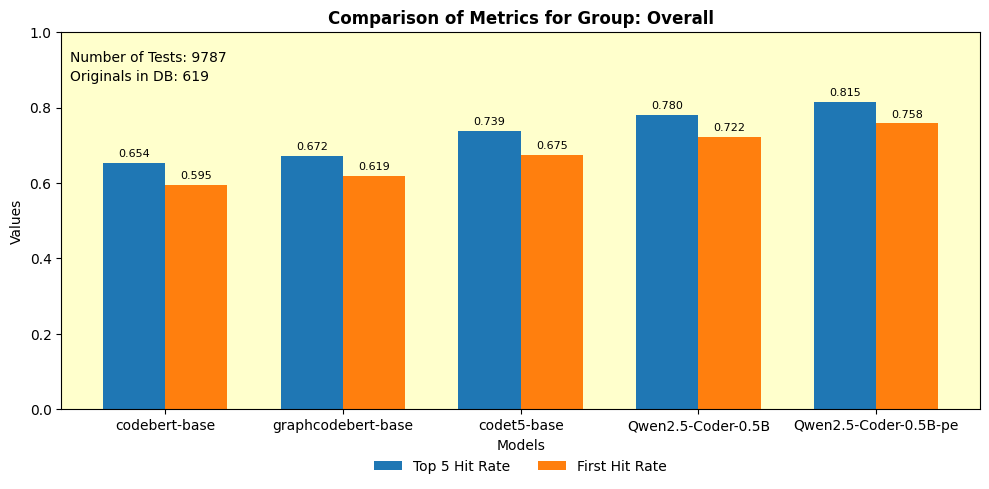

Loaded latest evaluation for codebert-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\codebert-base\global-clone\codebert-base_global_clone_search_evaluation_19.11.2024_17-21-46.csv
Successfully processed model: codebert-base, Group: T4
Loaded latest evaluation for graphcodebert-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\graphcodebert-base\global-clone\graphcodebert-base_global_clone_search_evaluation_19.11.2024_17-21-50.csv
Successfully processed model: graphcodebert-base, Group: T4
Loaded latest evaluation for codet5-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\codet5-base\global-clone\codet5-base_global_clone_search_evaluation_19.11.2024_17-21-53.csv
Successfully processed model: codet5-base, Group: T4
Loaded latest evaluation for Qwen2.5-Coder-0.5B: c:\Users\eitan\OneDrive\Deskto

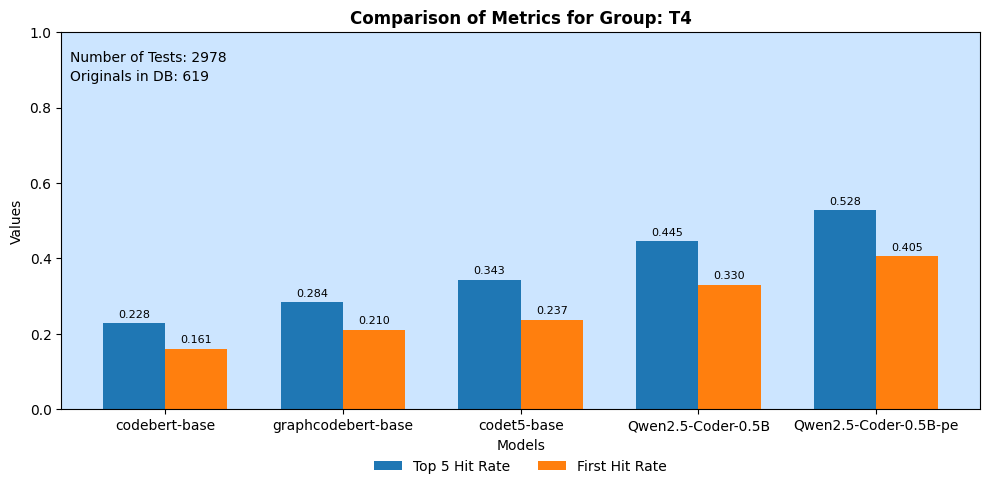

Loaded latest evaluation for codebert-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\codebert-base\global-clone\codebert-base_global_clone_search_evaluation_19.11.2024_17-21-46.csv
Successfully processed model: codebert-base, Group: T4 - Same Language
Loaded latest evaluation for graphcodebert-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\graphcodebert-base\global-clone\graphcodebert-base_global_clone_search_evaluation_19.11.2024_17-21-50.csv
Successfully processed model: graphcodebert-base, Group: T4 - Same Language
Loaded latest evaluation for codet5-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\codet5-base\global-clone\codet5-base_global_clone_search_evaluation_19.11.2024_17-21-53.csv
Successfully processed model: codet5-base, Group: T4 - Same Language
Loaded latest evaluation for Qw

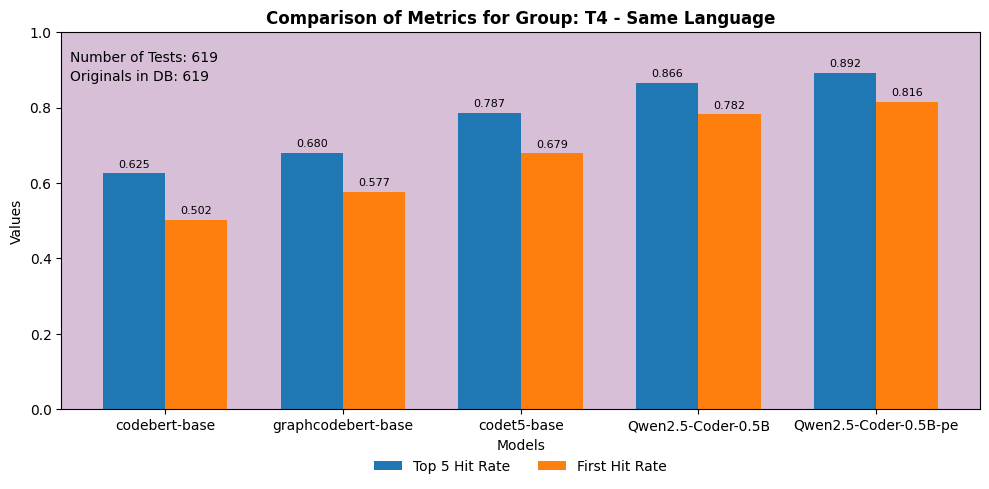

Loaded latest evaluation for codebert-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\codebert-base\global-clone\codebert-base_global_clone_search_evaluation_19.11.2024_17-21-46.csv
Successfully processed model: codebert-base, Group: T4 - Different Language
Loaded latest evaluation for graphcodebert-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\graphcodebert-base\global-clone\graphcodebert-base_global_clone_search_evaluation_19.11.2024_17-21-50.csv
Successfully processed model: graphcodebert-base, Group: T4 - Different Language
Loaded latest evaluation for codet5-base: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\codet5-base\global-clone\codet5-base_global_clone_search_evaluation_19.11.2024_17-21-53.csv
Successfully processed model: codet5-base, Group: T4 - Different Language
Loaded latest ev

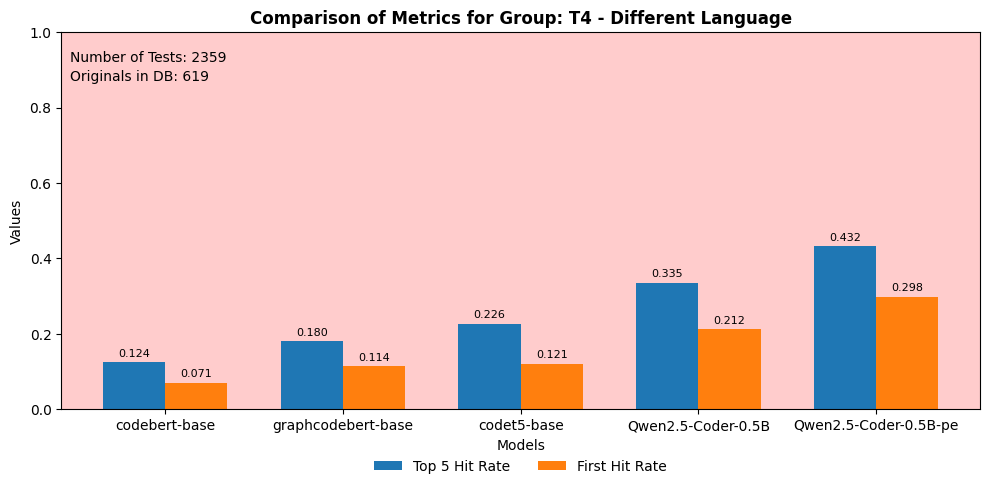

In [6]:
def main():
    """
    Main function to process all models and plot metrics for all groups.
    """
    groups_to_plot = ["Overall", "T4", "T4 - Same Language", "T4 - Different Language"]  # Groups to plot
    background_colors = ["#ffffcc", "#cce5ff", "#d8bfd8", "#ffcccc"]  # Colors for each group
    num_originals = 619  # Example number of original code snippets
    AVAILABLE_MODELS = ["codebert-base", "graphcodebert-base", "codet5-base", "Qwen2.5-Coder-0.5B", "Qwen2.5-Coder-0.5B-pe"]
    print(AVAILABLE_MODELS)

    for group, bg_color in zip(groups_to_plot, background_colors):
        models = []
        metrics_data = []
        num_tests = None  # Initialize the 'Number of Tests' variable

        for model_name in AVAILABLE_MODELS:
            # print(model_name)
            num_tests = process_model_and_group(model_name, group, models, metrics_data, num_tests)

        process_group(group, models, metrics_data, num_tests, num_originals, bg_color)


# Entry point
if __name__ == "__main__":
    main()

Loaded latest evaluation for Qwen2.5-Coder-0.5B-pe: c:\Users\eitan\OneDrive\Desktop\TAU\Third Year\Semester B\Industry Project\final-benchmark\benchmark\output\Qwen2.5-Coder-0.5B-pe\global-clone\Qwen2.5-Coder-0.5B-pe_global_clone_search_evaluation_20.11.2024_12-02-29.csv


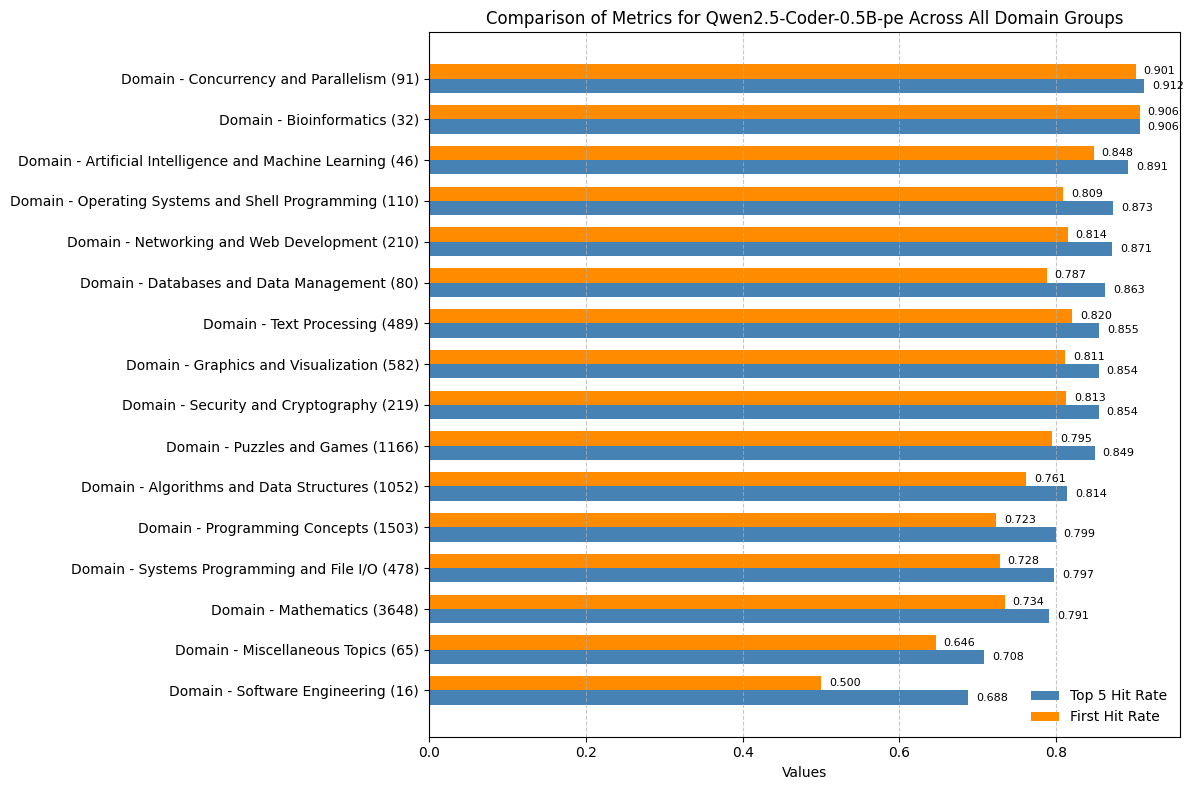

In [26]:
def plot_selected_model_domain_groups(data, model_name, metrics, title):
    """
    Plot a horizontal bar chart for a single selected model across all 'Domain - ...' groups.

    Args:
        data (pd.DataFrame): The dataset containing domain group metrics.
        model_name (str): The name of the model.
        metrics (list): List of metrics to include (e.g., 'Top 5 Hit Rate', 'First Hit Rate').
        title (str): Title of the chart.
    """
    import numpy as np

    # Filter for 'Domain - ...' groups
    filtered_data = data[data['Group'].str.startswith('Domain - ')]

    # Ensure there is data for the selected model
    if filtered_data.empty:
        print(f"No 'Domain - ...' groups available for model '{model_name}'.")
        return

    # Sort data by 'Top 5 Hit Rate' (or any other metric) for clarity
    filtered_data = filtered_data.sort_values(by=metrics[0], ascending=True)

    # Create domain labels with the number of tests appended
    domain_labels = [
        f"{row['Group']} ({int(row['Number of Tests'])})"
        for _, row in filtered_data.iterrows()
    ]

    # Extract metrics for the selected domain groups
    metrics_values = {metric: filtered_data[metric].values for metric in metrics}

    # Bar positions
    y = np.arange(len(domain_labels))  # Positions for the bars
    bar_height = 0.35  # Height of each bar

    fig, ax = plt.subplots(figsize=(12, len(domain_labels) * 0.5))  # Dynamically adjust height

    # Plot each metric with a distinct color
    colors = ['steelblue', 'darkorange']  # Define colors for metrics
    for i, (metric, values) in enumerate(metrics_values.items()):
        ax.barh(
            y + i * bar_height,  # Shift the bar positions vertically
            values,
            bar_height,
            label=metric,
            color=colors[i % len(colors)]
        )

    # Add numbers to the right of each bar
    for metric_index, (metric, values) in enumerate(metrics_values.items()):
        for i, value in enumerate(values):
            ax.text(
                value + 0.01,  # Slightly to the right of the bar
                y[i] + metric_index * bar_height,  # Centered vertically
                f"{value:.3f}",  # Format to 3 decimal places
                va="center", fontsize=8
            )

    # Configure the chart
    ax.set_yticks(y + bar_height / 2 * (len(metrics) - 1))
    ax.set_yticklabels(domain_labels)
    ax.set_xlabel("Values")
    ax.set_title(title)
    ax.legend(loc="lower right", frameon=False)
    ax.grid(axis="x", linestyle="--", alpha=0.7)  # Add gridlines for clarity

    # Remove excess space
    plt.tight_layout()
    plt.show()



# Select the model and metrics
selected_model = "Qwen2.5-Coder-0.5B-pe"
metrics = ['Top 5 Hit Rate', 'First Hit Rate']

# Process the evaluation DataFrame for the selected model
evaluation_df = process_model(selected_model)
if evaluation_df is not None:
    # Plot all 'Domain - ...' groups
    plot_selected_model_domain_groups(
        evaluation_df, 
        selected_model, 
        metrics, 
        f"Comparison of Metrics for {selected_model} Across All Domain Groups"
    )